In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Stations, Daily
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Join All Hourly Data

In [2]:
# setting the path for joining multiple files
files = os.path.join("../data/epa/TXHOURLY", "*tx*.csv")

# list of merged files returned
files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...");

# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
cols = ['ORISPL_CODE', 'UNITID', 'OP_DATE','OP_HOUR', 'GLOAD (MW)', 'SO2_RATE (lbs/mmBtu)',
       'NOX_RATE (lbs/mmBtu)', 'CO2_RATE (tons/mmBtu)', 'HEAT_INPUT (mmBtu)']
df = df[cols]
df['OP_DATE'] = pd.to_datetime(df['OP_DATE']).apply(lambda x: x.weekday())

Resultant CSV after joining all CSV files at a particular location...


## Import Crosswalk

In [4]:
cross = pd.read_csv('../crosswalks/EIA-EPA-Crosswalk/TX_crosswalk.csv')
cross = cross[['CAMD_PLANT_ID', 'EIA_LATITUDE', 'EIA_LONGITUDE']]
df = df.merge(cross, how='left', left_on='ORISPL_CODE', right_on='CAMD_PLANT_ID')
df.dropna(inplace=True)

KeyboardInterrupt: 

## Import Weather

In [17]:
def get_station(lat, lon):
    stations = Stations()
    stations = stations.nearby(lat, lon)
    stations = stations.fetch()
    if stations.empty:
        return None
    return stations.index[0]

def get_weather(station, start, end):
    if station is None:
        return None
    data = Daily(station, start, end)
    data = data.fetch()
    if data.empty:
        return None
    data = data['tmax'][0]
    return data

In [19]:
df['tmax'] = df.apply(lambda x: get_weather(get_station(x['EIA_LATITUDE'], x['EIA_LONGITUDE']), x["OP_DATE"], x["OP_DATE"]), axis=1)

KeyboardInterrupt: 

In [3]:
df.dropna(inplace=True)
d = df.loc[df.OP_HOUR ==1]
d = pd.get_dummies(d, columns=['ORISPL_CODE', 'UNITID'])
X = d.drop('CO2_RATE (tons/mmBtu)', axis=1).to_numpy()
y = d['CO2_RATE (tons/mmBtu)'].to_numpy()

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Make Model Flat

In [4]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [35]:
model.coef_

array([-5.62062948e-16,  1.16742475e-05,  3.97126439e-03,  2.50369864e-02,
       -2.93773117e-07,  2.99553834e-02,  2.21287884e-02, -4.68927802e-03,
       -2.77810810e-03, -2.72896704e-03, -7.24662434e-03, -2.07713123e-03,
       -8.90401425e-03, -5.56402130e-03, -8.19367377e-03, -3.53967529e-03,
        9.91833156e-03, -7.37213356e-03, -8.93719333e-03, -6.75836754e-03,
       -4.90591340e-03, -4.53774873e-03, -6.55023902e-03, -8.16037104e-03,
       -5.89062974e-03, -6.67167367e-03, -3.91359447e-03, -7.65693904e-03,
       -2.42061519e-03, -6.64030093e-03, -2.28417215e-03, -1.96551089e-03,
       -8.15434467e-03, -7.97889072e-03, -6.81330286e-03, -6.13648857e-04,
       -6.39572119e-03, -6.32118570e-03, -2.51792763e-03, -6.75188927e-03,
        3.28715402e-02,  3.53830921e-02,  3.36257385e-02,  3.48759974e-02,
        3.55484904e-02,  1.79454374e-02,  2.21795991e-02,  1.96107902e-02,
       -6.20778072e-03,  3.61989437e-02,  2.30735423e-02, -2.92744355e-03,
       -2.84755573e-03, -

## Make Model Score

In [28]:
print("Mean squared error: %.6f" % mean_squared_error(y_test, pred))

Mean squared error: 0.000014


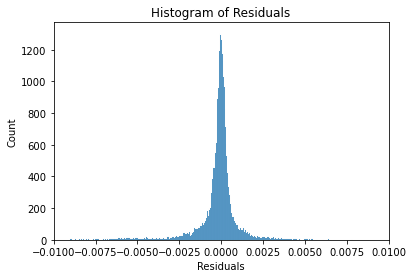

In [48]:
sns.histplot(pred-y_test)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.xlim(-0.01, 0.01)
plt.savefig("Res_hist.png", dpi=300)

Text(0.5, 1.0, 'CO2_RATE (tons/mmBtu) Distribution')

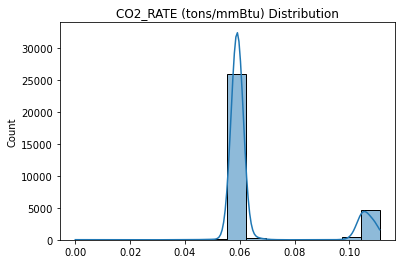

In [11]:
sns.histplot(y_test, kde=True)
plt.title("CO2_RATE (tons/mmBtu) Distribution")

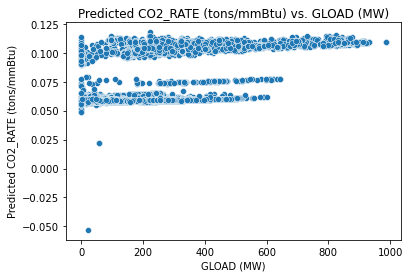

In [5]:
sns.scatterplot(X_test[:,2], pred)
plt.title("Predicted CO2_RATE (tons/mmBtu) vs. GLOAD (MW)")
plt.xlabel("GLOAD (MW)")
plt.ylabel("Predicted CO2_RATE (tons/mmBtu)")
plt.savefig("CO2_LinReg.svg", dpi=300)

<AxesSubplot:xlabel='truth', ylabel='pred'>

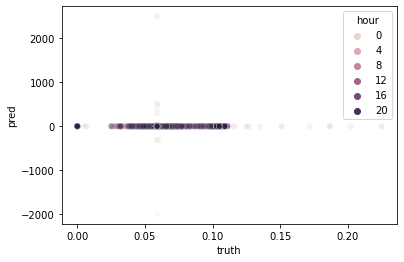

In [3]:
preds = pd.read_csv('./preds.csv')
sns.scatterplot(x = "truth", y = "pred", data = preds, hue = "hour", alpha = 0.1)